# Notas del video

***Dato: para este punto tendremos varias cosas en un Layers.py como la función Normalize y num_params. De momento no se agrega para fines del ejercicio.***
    
## Primera aplicación:***Crear una flor a partir de ruido***

In [8]:
import random 
import gc

import torch 
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor, ToPILImage

import fastai.vision.all as fv
from fastai.callback.hook import hook_outputs #con esto vamos a medir la diferencia entre lo que arrojan las activaciones

from fastprogress.fastprogress import progress_bar


###Nota: poner esto en un archivo .py en un futuro muy próximo
def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

class Normalize(nn.Module):
    def __init__(self, mean=fv.imagenet_stats[0], std=fv.imagenet_stats[1]):
        super().__init__()
        mean = torch.tensor(mean)
        std = torch.tensor(std)
        assert(len(mean.shape)==1)
        assert(len(std.shape)==1)
        self.mean = mean[None,:,None,None]
        self.std = std[None,:,None,None]
        
    def forward(self, x):
        m,s = self.mean.to(x),self.std.to(x)
        return (x-m)/s

In [9]:
to_pil=ToPILImage()
to_tensor=ToTensor()

In [10]:
size=(384,256)

Comencemos con crear una imagen de tamaño 384x256 y la pondremos una variable. Lo pasaremos a un tensor y lo normalizamos porque (más adelante) vamos a usar una red pre-entrenada que espera cosas normalizadas de input. 

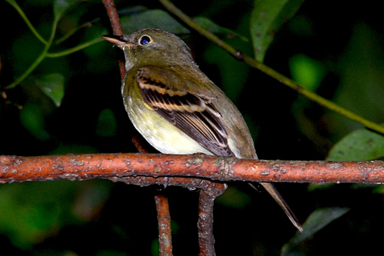

In [17]:
content_img = fv.PILImage.create("birds2/Birds/images/Acadian_Flycatcher_0013_29232.jpg").resize(size)
content_img

In [18]:
content_tensor = Normalize()(to_tensor(content_img)[None]) #Ese 1 es para pasarla por la re neuronal

In [20]:
content_tensor.shape

torch.Size([1, 3, 256, 384])

In [23]:
#Estas funciones auxiliares solamente son para ir viendo nuestro resultados

def denorm(t):
    mean,sd = (torch.tensor(x) for x in fv.imagenet_stats)
    mean,sd = mean[:,None,None], sd[:,None,None]
    return mean+ t*sd

def view(t):
    t = t.detach().cpu() #le quita los gradientes
    if len(t.shape) == 4:
        t = t[0] # la aplasta
    return to_pil(denorm(t).clamp(0,1))

In [24]:
content_tensor = content_tensor.cuda() #esto solamente es para que sea más rápido

Vamos a crear ruido, el cual vamos a pasar a la imagen que tengo arriba. Lo que estamos optimizando ahora son los pixeles en sí. Por eso necesitamos el gradiente

In [25]:
noise = torch.randn_like(content_tensor,requires_grad=True)

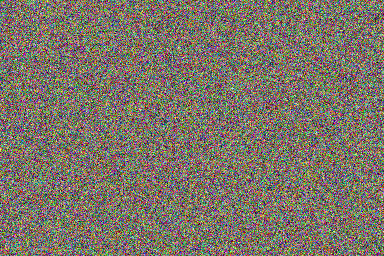

In [26]:
view(noise)

In [28]:
pbar = progress_bar(range(1000)) 
optimizer = torch.optim.Adam([noise],lr=1e-1)
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = F.mse_loss(noise,content_tensor)#Es justo lo que estábamos comentando que tomamos distancia pixel a pixel
    pbar.comment = f"loss={loss.item()}"
    
    loss.backward()
    optimizer.step()

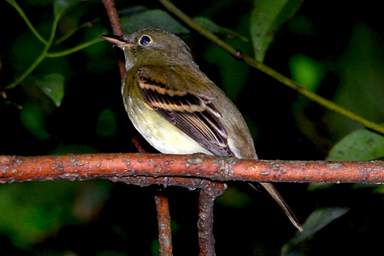

In [29]:
view(noise)

## Pérdida perceptual: Feature/Perceptual Loss

Ahora no usaremos c/pixel, sino una red pre-entrenada: VGG (donde básicamente usemos Max Pool o Average Pool) porque a esta red le interesa que las cosas se parezan (como que "piensa" en las formas y las texturas) y no que sean iguales. Ambas imágenes (la que tenemos y la que generamos) las vamos a pasar por la red neuronal, las activaciones vamos a tratar que se parezcan. 

In [101]:
class PerceptualLoss(nn.Module):
    def __init__(self,model,layer_ids, weights=[1,3,8,12,20,10]): #estos pesos se ponen artesanalmente. Gatys hizo diferentes experimentos con eso
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids] 
        self.hooks = hook_outputs(self.important_layers, detach=False) #Le pone unos ganchos que guardan lo que sale de las capas que pasemos
        self.weights = weights 

    def extract_features(self,x,clone=False):
        self.model(x)
        features = list(self.hooks.stored) #stored es donde se guardan las cosas

        if clone:
            features = [f.clone() for f in features] #aquí ponemos lo que salió de todas esas capas en una lista

        return features

    def forward(self,x,content_image):
        x_features = self.extract_features(x)
        content_features = self.extract_features(content_image, clone=True)

        return sum([F.mse_loss(a,b)*w for a,b,w in zip(x_features,content_features,self.weights)]) 

    def __del__(self):
        self.hooks.remove() #para que limpie todo cuando termine
    

Vamos a crear el modelo, tomar sus features, tomar gradientes, capas con Max Pool y crear el perceptual_loss (lo pasamos a cuda).

In [102]:
vgg = fv.vgg16_bn(pretrained=True) #ésta es mi red neuronal

In [103]:
vgg #verás que al final tiene un Average Pool y un Classifier

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [104]:
vgg = vgg.features
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [105]:
for p in vgg.parameters():
    p.requires_grad_(False) #no es necesario, pero hace todo más rápido

In [106]:
good_blocks = [i for i,m in enumerate(vgg) if type(m)==nn.MaxPool2d]
good_blocks

[6, 13, 23, 33, 43]

In [107]:
perceptual_loss = PerceptualLoss(vgg,good_blocks).cuda()

In [108]:
noise = torch.randn_like(content_tensor,requires_grad=True)

In [109]:
optimizer = torch.optim.Adam([noise],lr=1e-1)

In [110]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()

    loss = perceptual_loss(noise, content_tensor)
    pbar.comment = f"loss = {loss.item():.3f}"
    
    loss.backward()
    optimizer.step()

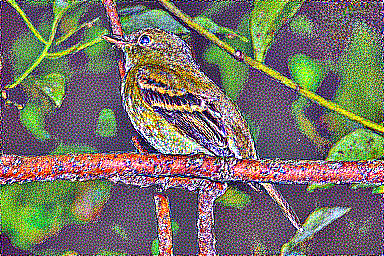

In [111]:
view(noise)

## Agregando estilo

Esta vez vamos a comenzar con la imagen perfecta. Y es que la idea de Gatys es **entender el estilo como la corrleación entre los diferentes canales de las activaciones**. Por ejemplo, cuando haya un círculo hay que ponerlo amarillo, un canar va a detectar el círculo. La correlación que mencionamos tomamos el producto de matrices (produce matriz de Gram... la esperanza del producto), cuánta correlación tenemos es lo que define nuestro estilo.

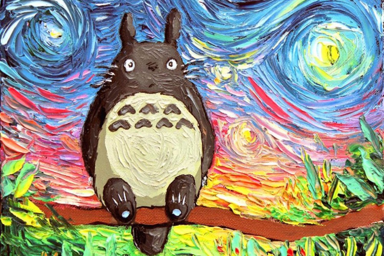

In [118]:
style = fv.PILImage.create("starry.jpg").resize(size)
style

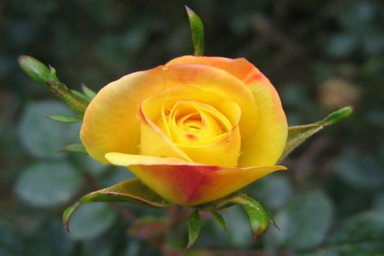

In [123]:
content = fv.PILImage.create("flowers/train/rose/image_01185.jpg").resize(size)
content

In [124]:
style_tensor = Normalize()(to_tensor(style)).cuda()

In [125]:
content_tensor = Normalize()(to_tensor(content)).cuda()

In [126]:
def gram_matrix(x):
    bs,c,h,w = x.shape
    x = x.view(bs,c,h*w)
    return (x@x.transpose(1,2)/(c*h*w)) #todos los canales contra todos los canales

In [166]:
##la copié de arriba y agrego la diferencia entre las matrices de Gram. Ésa es la pérdida del estylo
class StyleAndContentLoss(nn.Module):
    def __init__(self,model,layer_ids, content_weights=[1,3,8,12,20,10], style_weights=[20,25,15,10,4], style_mult=8e3): 
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids] 
        self.hooks = hook_outputs(self.important_layers, detach=False)
        self.content_weights = content_weights 
        self.style_weights = style_weights
        self.style_mult = style_mult

    def extract_features(self, x, clone=False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone: 
            features = [f.clone() for f in features]
            
        return features
    
    def content_loss(self, A, B):
        return sum([F.l1_loss(a,b)*w for a, b, w in zip(A, B, self.content_weights)])
    
    def style_loss(self,A,B): #pérdida del estilo
        #esta pérdida es muuuucho menor que la otra, había que poner pesos enormes, entonces mejor agregarmos un factor de multiplicación
        return sum([F.l1_loss(gram_matrix(a),gram_matrix(b))*w for a,b,w in zip(A,B,self.style_weights)])
        

    def forward(self,x,content_image,style_image):
        x_features = self.extract_features(x)
        content_features = self.extract_features(content_image, clone=True)
        style_features = self.extract_features(style_image, clone=True)

        
        self.CL = self.content_loss(x_features, content_features)
        self.SL = self.style_mult*self.style_loss(x_features,style_features)
        
        return self.CL + self.SL

    def __del__(self):
        self.hooks.remove()



In [167]:
def style_content_loss(**kwargs):
    vgg = fv.vgg16_bn(pretrained=True)
    vgg.eval()
    vgg = vgg.features
    for p in vgg.parameters(): p.requires_grad_(False)
    good_blocks = [i for i,o in enumerate(vgg.children()) if isinstance(o, nn.MaxPool2d)]
    
    return StyleAndContentLoss(vgg, layer_ids=good_blocks, **kwargs)

In [168]:
content_and_style_loss = style_content_loss().cuda()

In [169]:
optimizer = torch.optim.Adam([noise],lr=1e-1)

In [170]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss(noise, content_tensor, style_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss.CL:.2f} | style_loss = {content_and_style_loss.SL:.2f} | total loss = {loss.item():.2f}"
    
    loss.backward()
    optimizer.step()

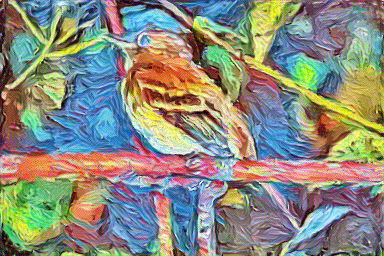

In [172]:
view(noise)

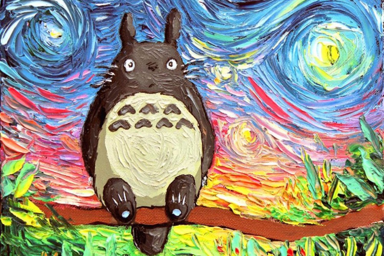

In [173]:
style

# Transferencia de estilo: tarea
1. Recrea la libreta de transferencia de estilo con: fotos diferentes (puedes dejar starry night si quieres, pero la otra cámbiala). --Done (ver arriba)
2. Modifica StyleAndContentLoss como mencioné en el video para que sea mucho más rápida: Modifica init para que le pases la imagen de contenido y de estilo y que las pase sólo una vez por la red y guarde lo que sale.
3. Después, a la hora de calcular la función de pérdida, sólo pasará la imagen a optimizar UNA vez por la red, y las otras dos ya no será necesario :)

In [206]:
noise = torch.randn_like(content_tensor,requires_grad=True)

In [207]:
optimizer = torch.optim.Adam([noise],lr=1e-1)

In [209]:
class StyleAndContentLoss(nn.Module):
    def __init__(self,model,layer_ids,content_image, style_image,content_weights=[1,3,8,12,20,10], style_weights=[20,25,15,10,4], style_mult=8e3): 
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.content_image = content_image #*-----------
        self.stye_image = style_image #*----------------
        self.hooks = hook_outputs(self.important_layers, detach=False)
        self.content_weights = content_weights 
        self.style_weights = style_weights
        self.style_mult = style_mult
        
        self.content_features = self.extract_features(content_image, clone=True)
        self.style_features = self.extract_features(style_image, clone=True)

    def extract_features(self, x, clone=False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone: 
            features = [f.clone() for f in features]
            
        return features
    
    def content_loss(self, A, B):
        return sum([F.l1_loss(a,b)*w for a, b, w in zip(A, B, self.content_weights)])
    
    def style_loss(self,A,B): 
        return sum([F.l1_loss(gram_matrix(a),gram_matrix(b))*w for a,b,w in zip(A,B,self.style_weights)])

    def forward(self,x,content_image,style_image):
        x_features = self.extract_features(x)
        
        self.CL = self.content_loss(x_features, self.content_features)
        self.SL = self.style_mult*self.style_loss(x_features, self.style_features)
        
        return self.CL + self.SL

    def __del__(self):
        self.hooks.remove()

In [210]:
def style_content_loss(content_image,style_image,**kwargs):
    vgg = fv.vgg16_bn(pretrained=True)
    vgg.eval()
    vgg = vgg.features
    for p in vgg.parameters(): p.requires_grad_(False)
    vgg = vgg.cuda()
    
    good_blocks = [i for i,o in enumerate(vgg.children()) if isinstance(o, nn.MaxPool2d)]
    
    return StyleAndContentLoss(vgg, layer_ids=good_blocks,content_image=content_image,style_image=style_image, **kwargs)

In [211]:
content_and_style_loss = style_content_loss(content_tensor,style_tensor).cuda()

In [212]:
pbar = progress_bar(range(2000))
for epoch in pbar:
    optimizer.zero_grad()
    
    loss = content_and_style_loss(noise, content_tensor, style_tensor)
    pbar.comment = f"| content_loss = {content_and_style_loss.CL:.2f} | style_loss = {content_and_style_loss.SL:.2f} | total loss = {loss.item():.2f}"
    
    loss.backward()
    optimizer.step()

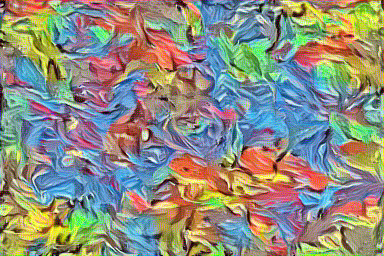

In [213]:
view(noise)